In [2]:
# include common functions from a file for easier sharing across notebooks
# NOTE: CAN be edited using jupyter :)

include("./common_functions.jl")

In [49]:
# load data

# image_files = get_image_files("./beer1800")
# image_files = get_image_files("./lowres_flowers_set")
# image_files = get_image_files("./grayscale")
# image_files = get_image_files("./music0500")
image_files = get_image_files("./small_set")
# image_files = get_image_files("./small_set_2")
# image_files = get_image_files("./avengers")

images_mat = load_images_as_cellarray_mats(image_files)
desired_size = (32,32)
# images_mat = subsample_cellarray_mats(images_mat, desired_size)
# images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded")

# test_image = test_images_mat[1] # qr code
# test_image = test_images_mat[2] # dog
# test_image = test_images_mat[3] # frog
# test_image = test_images_mat[4] # iron man
test_image = test_images_mat[5] # wisconsin state capitol

; # to suppress display

50 basis image files loaded
5 test image files loaded


In [50]:
# precompute data required for LP formulation

# range of basis downscaling to be considered
# downscaling = 1 means do not downscale
desired_downscaling = 4

max_downscaling_height = floor( log2(size(images_mat[1],1)) )
max_downscaling_width = floor( log2(size(images_mat[1],2)) )

downscaling = round(Int, min(desired_downscaling, max_downscaling_height, max_downscaling_width))

n_basis = length(images_mat)
h_test, w_test, n_colors = size(test_image)
h_basis, w_basis, n_colors = size(images_mat[1])
    
h_basis_smallest = div(h_basis, 2^(downscaling-1))
w_basis_smallest = div(w_basis, 2^(downscaling-1))
    
h_grid_test_image = div(h_test, h_basis_smallest)
w_grid_test_image = div(w_test, w_basis_smallest)

println("n_basis = ", n_basis)
println("h_test, w_test, n_colors = ", (h_test, w_test, n_colors) )
println("h_basis, w_basis, n_colors = ", (h_basis, w_basis, n_colors) )
println("h_basis_smallest, w_basis_smallest = ", (h_basis_smallest, w_basis_smallest) )
println("h_grid_test_image, w_grid_test_image = ", (h_grid_test_image, w_grid_test_image) )
println("downscaling = ", downscaling)

memory_needed = (h_grid_test_image * w_grid_test_image * (2^downscaling-1)^2 * n_colors * downscaling * n_basis * 2) / 1e9 # GB
println("Memory Needed = ", memory_needed, " GB")

n_basis = 50
h_test, w_test, n_colors = (640,960,3)
h_basis, w_basis, n_colors = (64,64,3)
h_basis_smallest, w_basis_smallest = (8,8)
h_grid_test_image, w_grid_test_image = (80,120)
downscaling = 4
Memory Needed = 2.592 GB


In [51]:
function calculate_mean_errors(test_image, images_mat, downscaling)
    default_error = 1000
    # grid_h_, grid_w, basis_top_h, basis_left_w, n_colors, downscaling, n_basis
    # mean_errors = default_error*ones(Float16, h_grid_test_image, w_grid_test_image,
    #                                           h_grid_test_image, w_grid_test_image, n_colors, downscaling, n_basis)
    
    mean_errors = cell(downscaling,1)
    for scale in 1:downscaling
        mean_errors[scale] = default_error*ones(Float16, h_grid_test_image, w_grid_test_image,
                                                2^(downscaling-scale), 2^(downscaling-scale), n_colors, n_basis)
    end
    
    possible_bases_for_grid_location = cell(h_grid_test_image, w_grid_test_image)
    # initialize the possible_bases_for_grid_location
    for j in 1:h_grid_test_image
        for i in 1:w_grid_test_image
            possible_bases_for_grid_location[j, i] = []
        end
    end
    
    # return mean_errors, possible_bases_for_grid_location
    
    for scale in 1:downscaling
        h_grid_basis_image = 2^(downscaling-scale)
        w_grid_basis_image = 2^(downscaling-scale)
        
        @showprogress for basis in 1:n_basis
            basis_image = downscale_image(images_mat[basis], 2^(scale-1))
            
            for top_grid_y in 1:(h_grid_test_image-h_grid_basis_image+1)
                top_y = (top_grid_y-1)*h_basis_smallest + 1
                bottom_y = (top_grid_y-1+h_grid_basis_image)*h_basis_smallest
                
                for left_grid_x in 1:(w_grid_test_image-w_grid_basis_image+1)
                    left_x = (left_grid_x-1)*w_basis_smallest + 1
                    right_x = (left_grid_x-1+w_grid_basis_image)*w_basis_smallest
                    
                    sub_test_image = test_image[top_y:bottom_y, left_x:right_x, :]
                    
                    basis_image_error = basis_image - sub_test_image
                    abs_basis_image_error = abs(basis_image_error)
                    
                    for top_subgrid_y in top_grid_y:min( (top_grid_y+h_grid_basis_image-1) , h_grid_test_image )
                        top_sub_y = (top_subgrid_y-top_grid_y)*h_basis_smallest + 1
                        bottom_sub_y = (top_subgrid_y-top_grid_y+1)*h_basis_smallest
                        
                        for left_subgrid_x in left_grid_x:min( (left_grid_x+w_grid_basis_image-1) , w_grid_test_image )
                            left_sub_x = (left_subgrid_x-left_grid_x)*w_basis_smallest + 1
                            right_sub_x = (left_subgrid_x-left_grid_x+1)*w_basis_smallest
                            
                            push!(possible_bases_for_grid_location[top_subgrid_y, left_subgrid_x], 
                                                    (top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, scale, basis) )
                            
                            for color in 1:n_colors
                                mean_abs_error = mean(abs_basis_image_error[top_sub_y:bottom_sub_y, 
                                                                            left_sub_x:right_sub_x, color])
                                
                                # println("left_grid_x = ", left_grid_x)
                                # println("max left_grid_x = ", min( (left_grid_x+w_grid_basis_image-1) , w_grid_test_image ))
                                
                                # println((top_subgrid_y, left_subgrid_x,
                                #                top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, 
                                #                color, basis));
                                
                                if mean_errors[scale][top_subgrid_y, left_subgrid_x,
                                               top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, 
                                               color, basis] != default_error
                                    println("ERROR: reassigning error calculation")
                                    return nothing
                                end
                                
                                mean_errors[scale][top_subgrid_y, left_subgrid_x, 
                                            top_subgrid_y-top_grid_y+1, left_subgrid_x-left_grid_x+1, 
                                            color, basis] = mean_abs_error
                                # end of color loop
                            end
                            # end of left_subgrid_x loop
                        end
                        # end of top_subgrid_y loop
                    end
                    
                    # end of left_grid_x loop
                end
                
                #end of top_grid_y loop
            end
            
            # end of basis loop
        end
        
        # end of scaling loop
    end
    
    return mean_errors, possible_bases_for_grid_location
end

@time mean_errors, possible_bases_for_grid_location = calculate_mean_errors(test_image, images_mat, downscaling)

# sanity check
for h_grid in 1:h_grid_test_image
    for w_grid in 1:w_grid_test_image
        if (length(possible_bases_for_grid_location[h_grid, w_grid]) == 0)
            println("ERROR: no possible bases for location = ", (h_grid, w_grid))
        end
    end
end

;

Progress: 100%|█████████████████████████████████████████| Time: 0:08:12
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
764.634268 seconds (3.19 G allocations: 115.163 GB, 45.29% gc time)


In [52]:
# LP formulation
using JuMP, Clp

# tradeoff parameter
λ = 0

# optimization model
m = Model(solver = ClpSolver())
    
# place_basis variable
@time @variable(m, 0 <= place_basis[1:h_grid_test_image, 1:w_grid_test_image, 1:downscaling, 1:n_basis] <= 1)

# exactly one basis must correspond to any location
@time @constraint(m, C_one_basis[h_grid in 1:h_grid_test_image, w_grid in 1:w_grid_test_image], sum{
            place_basis[h_grid-h_loc+1, w_grid-w_loc+1, scale, basis], 
            (h_loc, w_loc, scale, basis) in possible_bases_for_grid_location[h_grid, w_grid] 
            } == 1)

# total error
@time @expression(m, mosaic_error[h_grid in 1:h_grid_test_image, w_grid in 1:w_grid_test_image], sum{
    place_basis[h_grid-h_loc+1, w_grid-w_loc+1, scale, basis] * 
    mean( mean_errors[scale][h_grid, w_grid, h_loc, w_loc, 1:n_colors, basis] ),
    (h_loc, w_loc, scale, basis) in possible_bases_for_grid_location[h_grid, w_grid]
    })

# total downscaled basis
@time @expression(m, total_downscaled_bases, sum(place_basis[:, :, 2:downscaling, :]) )

@time @objective(m, Min, sum(mosaic_error) + λ * total_downscaled_bases )

@time status = solve(m)

  0.604030 seconds (3.94 M allocations: 236.774 MB)
105.644247 seconds (278.04 M allocations: 8.968 GB, 50.93% gc time)
240.346478 seconds (1.07 G allocations: 34.518 GB, 41.54% gc time)
  0.096048 seconds (22 allocations: 43.946 MB, 61.45% gc time)
 12.342532 seconds (55 allocations: 1.167 GB, 88.51% gc time)
 52.202839 seconds (131 allocations: 2.330 GB, 37.68% gc time)


:Optimal

 18.604737 seconds (7.48 M allocations: 542.538 MB, 20.39% gc time)


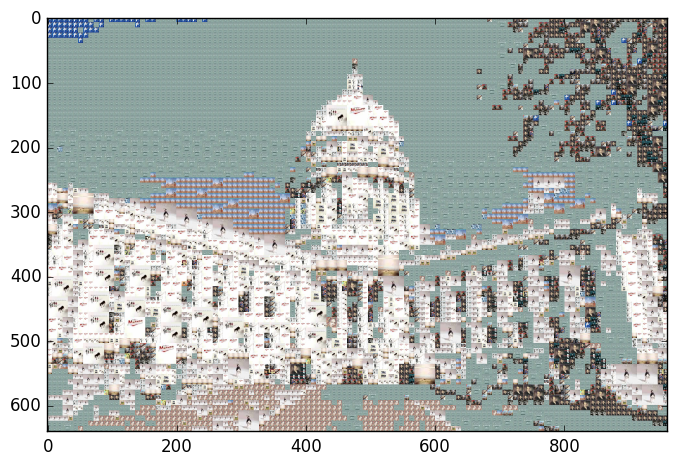

PyObject <matplotlib.image.AxesImage object at 0x000000001C4A68D0>

In [53]:
# construct mosaic image from solution
using PyPlot

function construct_mosaic_image(opt_place_basis)
    opt_place_basis = round(Int8, opt_place_basis)
    nonzero_indices = find(opt_place_basis)
    
    chosen_bases = [ ind2sub(opt_place_basis, nonzero_indices[i]) for i in 1:length(nonzero_indices) ]
    
    mosaic_image = similar(test_image)
    
    for choice in chosen_bases
        h_grid_loc = choice[1]
        w_grid_loc = choice[2]
        scale = choice[3]
        basis = choice[4]
        
        h_grid_basis_image = 2^(downscaling-scale)
        w_grid_basis_image = 2^(downscaling-scale)
        
        top_y = (h_grid_loc-1)*h_basis_smallest + 1
        bottom_y = (h_grid_loc-1+h_grid_basis_image)*h_basis_smallest
        
        left_x = (w_grid_loc-1)*w_basis_smallest + 1
        right_x = (w_grid_loc-1+w_grid_basis_image)*w_basis_smallest
        
        basis_image = downscale_image(images_mat[basis], 2^(scale-1))
        
        mosaic_image[top_y:bottom_y, left_x:right_x, :] = basis_image
    end
    
    return mosaic_image
end

opt_place_basis = getvalue(place_basis)
@time mosaic_image = construct_mosaic_image(opt_place_basis);

imshow(mosaic_image)

In [ ]:
for j in 1:h_grid_test_image
    break
    println("row ", j)
    for i in 1:w_grid_test_image
        println(mosaic_error[j, i])
    end
    println("")
end

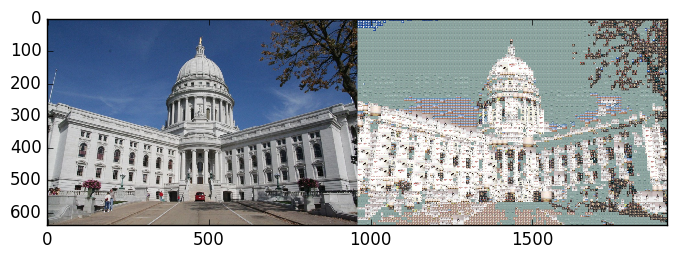

PyObject <matplotlib.image.AxesImage object at 0x000000001D3A4940>

In [54]:
imshow([test_image mosaic_image])
# imshow(test_images_mat[3])

In [40]:
print(mosaic_error[1,1])

186.1666717529297 place_basis[1,1,1,1] + 73.16666412353516 place_basis[1,1,1,2] + 137.1458282470703 place_basis[1,1,1,3] + 185.1666717529297 place_basis[1,1,1,4] + 186.1666717529297 place_basis[1,1,2,1] + 73.16666412353516 place_basis[1,1,2,2] + 137.1458282470703 place_basis[1,1,2,3] + 185.1666717529297 place_basis[1,1,2,4] + 186.1666717529297 place_basis[1,1,3,1] + 73.16666412353516 place_basis[1,1,3,2] + 137.1458282470703 place_basis[1,1,3,3] + 185.1666717529297 place_basis[1,1,3,4]

In [33]:
nonzero_indices = find(opt_place_basis)
chosen_bases = [ ind2sub(opt_place_basis, nonzero_indices[i]) for i in 1:length(nonzero_indices) ]    

1-element Array{Any,1}:
 (1,1,3,30)